In [4]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report


2024-12-17 21:40:48,771 - INFO - Loading data...
2024-12-17 21:40:49,256 - INFO - Visualizing category distribution...


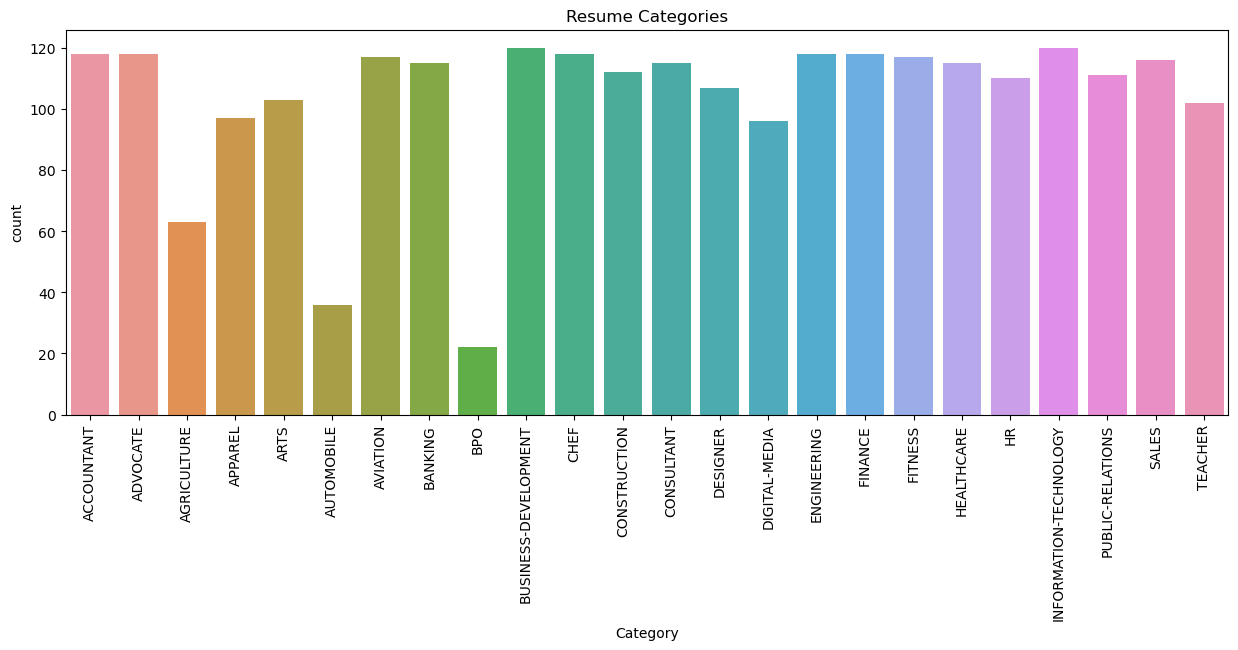

2024-12-17 21:40:50,296 - INFO - Balancing dataset...
2024-12-17 21:40:50,361 - INFO - Splitting data...
2024-12-17 21:40:50,371 - INFO - Vectorizing text data...
2024-12-17 21:41:00,738 - INFO - Training Random Forest Classifier with GridSearchCV...


Fitting 3 folds for each of 24 candidates, totalling 72 fits


2024-12-17 21:43:17,387 - INFO - Evaluating model performance...
2024-12-17 21:43:17,565 - INFO - Generating confusion matrix...


Accuracy: 0.9097222222222222
                        precision    recall  f1-score   support

            ACCOUNTANT       0.75      1.00      0.86        21
              ADVOCATE       1.00      0.82      0.90        28
           AGRICULTURE       0.94      0.70      0.80        23
               APPAREL       0.90      0.85      0.88        33
                  ARTS       1.00      0.76      0.86        29
            AUTOMOBILE       0.90      1.00      0.95        18
              AVIATION       0.97      1.00      0.98        29
               BANKING       0.84      0.73      0.78        22
                   BPO       1.00      1.00      1.00        23
  BUSINESS-DEVELOPMENT       0.72      0.87      0.79        15
                  CHEF       0.96      1.00      0.98        27
          CONSTRUCTION       1.00      1.00      1.00        31
            CONSULTANT       0.85      0.81      0.83        21
              DESIGNER       1.00      1.00      1.00        19
         D

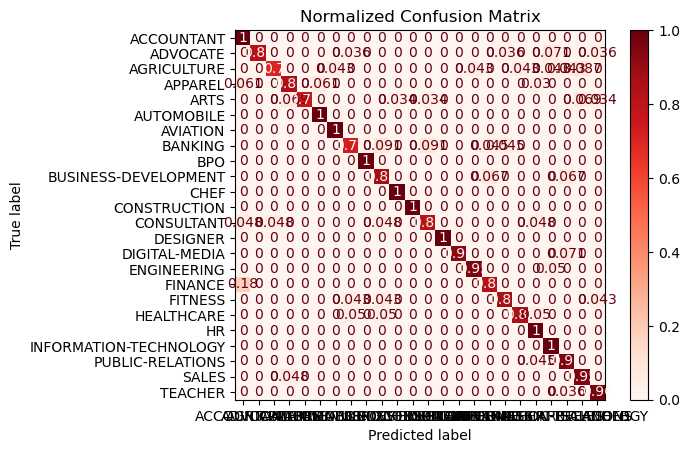

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tanay\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
2024-12-17 21:44:09,810 - INFO - Saving the model and vectorizer pipeline...
2024-12-17 21:44:15,642 - INFO - Process completed successfully!


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from joblib import dump
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import logging

# Enable logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load data
logging.info("Loading data...")
clean_df = pd.read_csv(r'C:\Users\tanay\Desktop\ATS\archive\clean_resume_data.csv')
clean_df['Category'] = clean_df['Category'].astype('category')

# Visualize data distribution
logging.info("Visualizing category distribution...")
plt.figure(figsize=(15, 5))
sns.countplot(x='Category', data=clean_df)
plt.xticks(rotation=90)
plt.title("Resume Categories")
plt.show()

# Balance the dataset
logging.info("Balancing dataset...")
max_count = clean_df['Category'].value_counts().max()
balanced_df = clean_df.groupby('Category', group_keys=False).apply(
    lambda x: x.sample(max_count, replace=True, random_state=42)
).reset_index(drop=True)

# Drop NA values from relevant columns
balanced_df.dropna(subset=['Feature', 'Category'], inplace=True)

# Split data into training and testing
logging.info("Splitting data...")
x = balanced_df['Feature']
y = balanced_df['Category']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Text vectorization
logging.info("Vectorizing text data...")
tfidf_vectorizer_categorization = TfidfVectorizer(
    max_features=5000, stop_words='english', ngram_range=(1, 2)
)
x_train_tfidf = tfidf_vectorizer_categorization.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer_categorization.transform(x_test)

# Hyperparameter tuning for Random Forest
logging.info("Training Random Forest Classifier with GridSearchCV...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_classifier_categorization = RandomForestClassifier(n_jobs=-1, random_state=42)
grid_search = GridSearchCV(rf_classifier_categorization, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(x_train_tfidf, y_train)
best_rf_model = grid_search.best_estimator_

# Evaluate the model
logging.info("Evaluating model performance...")
y_pred = best_rf_model.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
logging.info("Generating confusion matrix...")
ConfusionMatrixDisplay.from_estimator(
    best_rf_model,
    x_test_tfidf,
    y_test,
    display_labels=best_rf_model.classes_,
    cmap='Reds',
    normalize='true'
)
plt.title('Normalized Confusion Matrix')
plt.show()

# Clean resume function
nltk.download('stopwords')
nltk.download('punkt')

def cleanResume(txt):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(txt)
    cleaned_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(cleaned_tokens)

# Predict category
def predict_category(resume_text):
    resume_text = cleanResume(resume_text)
    resume_tfidf = tfidf_vectorizer_categorization.transform([resume_text])
    predicted_category = best_rf_model.predict(resume_tfidf)[0]
    return predicted_category

# Save the pipeline
logging.info("Saving the model and vectorizer pipeline...")
pipeline = Pipeline([
    ('vectorizer', tfidf_vectorizer_categorization),
    ('classifier', best_rf_model)
])
dump(pipeline, r'C:\Users\tanay\Desktop\ATS\models\resume_classifier_pipeline.joblib')

logging.info("Process completed successfully!")


In [2]:
clean_df=pd.read_csv(r'C:\Users\tanay\Desktop\ATS\archive\clean_resume_data.csv')

In [3]:
clean_df.head()

,ID,Category,Feature
0,16852973,HR,hr administrator marketing associate hr admini...
1,22323967,HR,hr specialist hr operations summary media prof...
2,33176873,HR,hr director summary years experience recruitin...
3,27018550,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR,hr manager skill highlights hr skills hr depar...


In [4]:
clean_df.shape

(2484, 3)

In [5]:
clean_df['Category'].value_counts()

INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: Category, dtype: int64

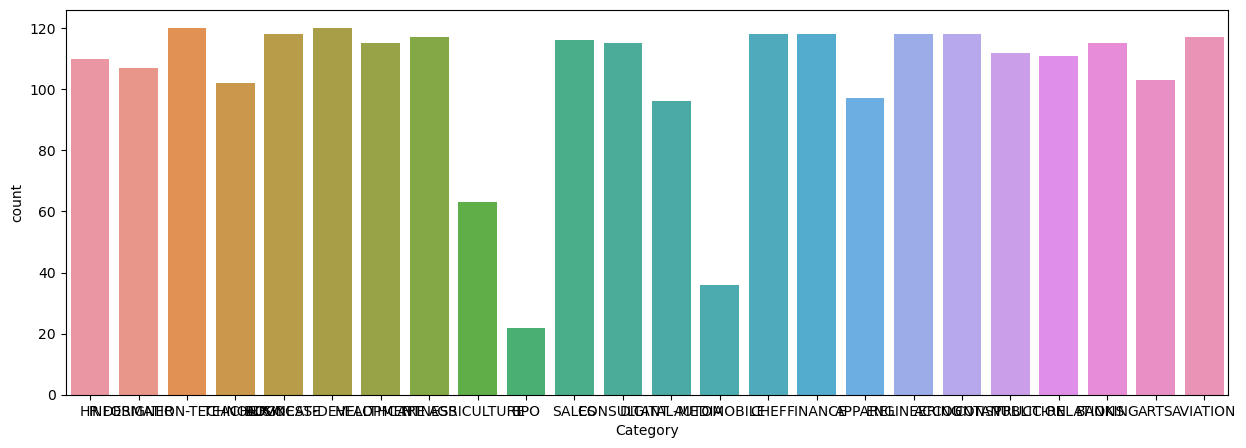

In [6]:
plt.figure(figsize=(15,5))
sns.countplot(x='Category', data=clean_df)
plt.show()

In [7]:
clean_df['Category'].unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

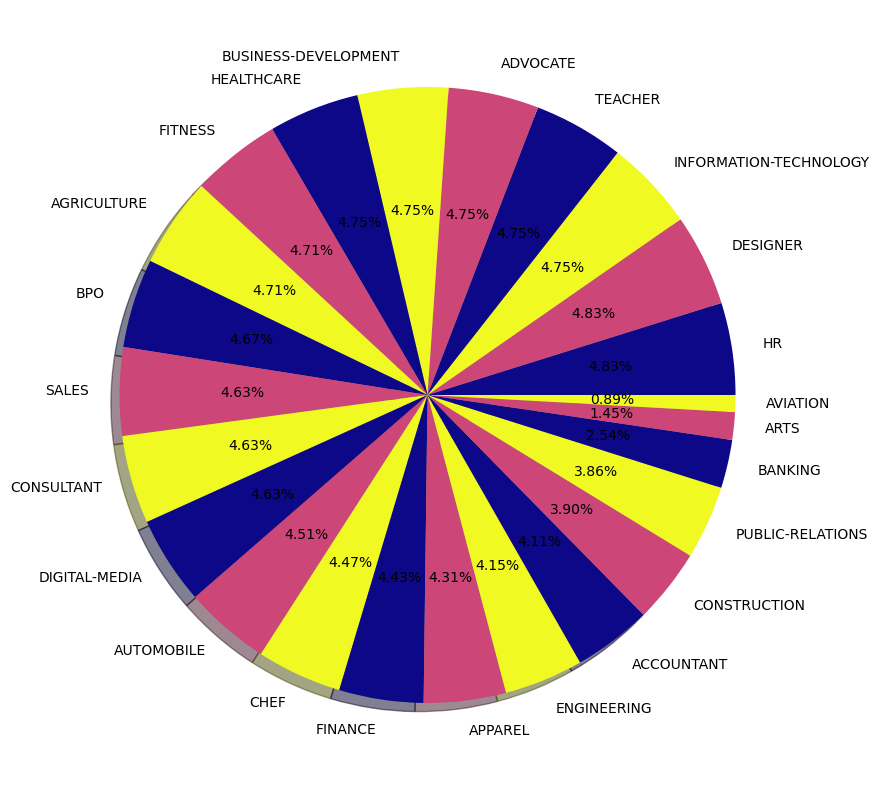

In [8]:
counts=clean_df['Category'].value_counts()
labels=clean_df['Category'].unique()
plt.figure(figsize=(15,10))
plt.pie(counts,labels=labels,autopct='%1.2f%%',shadow=True,colors=plt.cm.plasma(np.linspace(0,1,3)))
plt.show()

In [9]:
from sklearn.utils import resample
max_count=clean_df['Category'].value_counts().max()
balanced_data=[]
for category in clean_df['Category'].unique():
    #filtering
    category_data=clean_df[clean_df['Category']==category]
    if len(category_data)<max_count:
        balanced_category_data=resample(category_data,replace=True,n_samples=max_count,random_state=42)
    else:
        balanced_category_data=resample(category_data,replace=False,n_samples=max_count,random_state=42)
    balanced_data.append(balanced_category_data)
balanced_df=pd.concat(balanced_data)

In [10]:
balanced_df['Category'].value_counts()

HR                        120
DESIGNER                  120
ARTS                      120
BANKING                   120
PUBLIC-RELATIONS          120
CONSTRUCTION              120
ACCOUNTANT                120
ENGINEERING               120
APPAREL                   120
FINANCE                   120
CHEF                      120
AUTOMOBILE                120
DIGITAL-MEDIA             120
CONSULTANT                120
SALES                     120
BPO                       120
AGRICULTURE               120
FITNESS                   120
HEALTHCARE                120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  120
TEACHER                   120
INFORMATION-TECHNOLOGY    120
AVIATION                  120
Name: Category, dtype: int64

In [11]:
balanced_df.dropna(inplace=True)

In [12]:
x=balanced_df['Feature']
y=balanced_df['Category']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [13]:
#vectorization
tfidf_vectorizer_categorization=TfidfVectorizer()
x_train_tfidf=tfidf_vectorizer_categorization.fit_transform(x_train)
x_test_tfidf=tfidf_vectorizer_categorization.transform(x_test)


In [14]:
#training using random forest classifier
rf_classifier_categorization=RandomForestClassifier()
#fitting(80% data for training)
rf_classifier_categorization.fit(x_train_tfidf,y_train)
#accuracy evaluation
y_pred=rf_classifier_categorization.predict(x_test_tfidf)
accuracy=accuracy_score(y_test,y_pred)
print("Accuracy",accuracy)

Accuracy 0.8559027777777778


In [15]:
print(classification_report(y_test,y_pred))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.77      0.95      0.85        21
              ADVOCATE       0.96      0.86      0.91        29
           AGRICULTURE       0.95      0.83      0.88        23
               APPAREL       0.95      0.86      0.90        21
                  ARTS       0.93      0.64      0.76        22
            AUTOMOBILE       1.00      1.00      1.00        19
              AVIATION       0.93      0.93      0.93        30
               BANKING       1.00      0.78      0.88        23
                   BPO       1.00      1.00      1.00        15
  BUSINESS-DEVELOPMENT       0.44      0.61      0.51        18
                  CHEF       0.96      0.96      0.96        28
          CONSTRUCTION       0.86      1.00      0.93        25
            CONSULTANT       0.91      0.65      0.75        31
              DESIGNER       0.96      0.93      0.95        28
         DIGITAL-MEDIA       0.83      

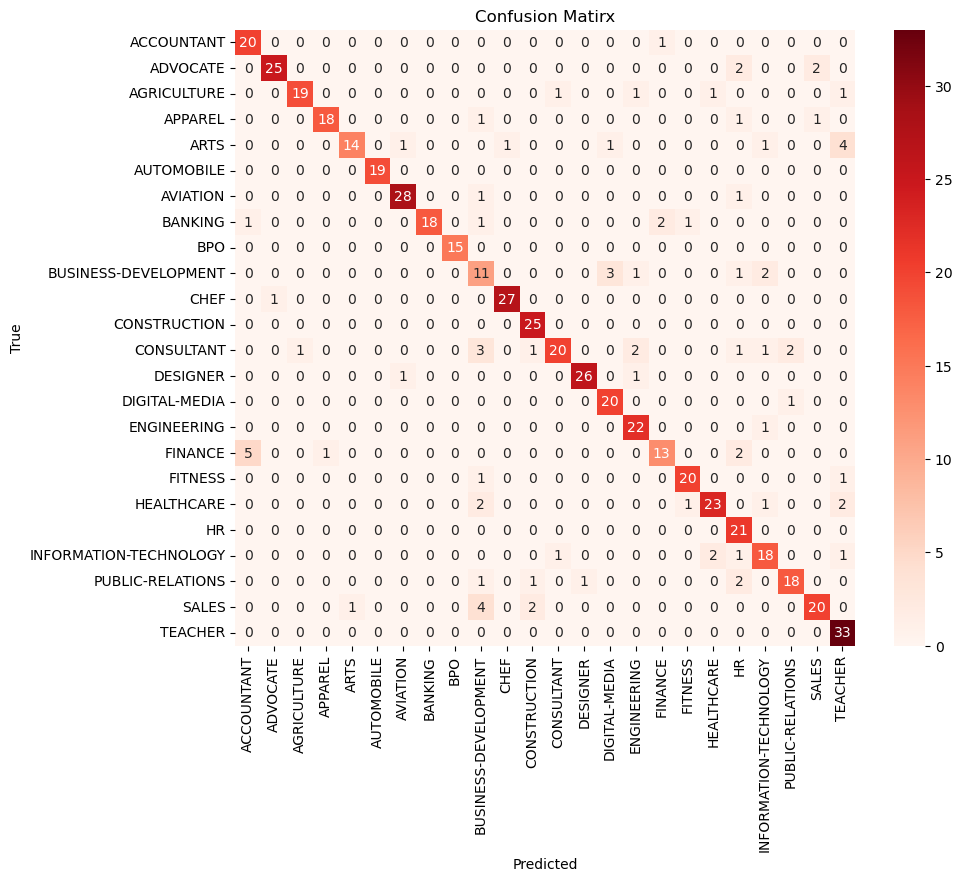

In [16]:
#CONFUSION MATRIXX
conf_matrix=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot=True, fmt='d',cmap='Reds',xticklabels=rf_classifier_categorization.classes_,yticklabels=rf_classifier_categorization.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matirx')
plt.show()

In [17]:
print(conf_matrix)

[[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  2  0]
 [ 0  0 19  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0  0  0  1]
 [ 0  0  0 18  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  1  0]
 [ 0  0  0  0 14  0  1  0  0  0  1  0  0  0  1  0  0  0  0  0  1  0  0  4]
 [ 0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 28  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0 18  0  1  0  0  0  0  0  0  2  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  0  0  3  1  0  0  0  1  2  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  3  0  1 20  0  0  2  0  0  0  1  1  2  0  0]
 [ 0  0  0  0  0  0  1  0

In [2]:
#clean resume
import re
def cleanResume(txt):
    cleanText=re.sub('http\S+\s',' ',txt)
    cleanText=re.sub('RT|cc','.',cleanText)
    cleanText=re.sub('#\S+\s','.',cleanText)
    cleanText=re.sub('@\S+','  ',cleanText)
    cleanText=re.sub('[%s]'%re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""))
    cleanText=re.sub(r'[^\x00-\x7f]', ' ', cleanText) 
    cleanText=re.sub('\s+', ' ', cleanText)
    return cleanText
    
def predict_category(resume_text):
    resume_text=cleanResume(resume_text)
    resume_tfidf=tfidf_vectorizer_categorization.transform([resume_text])
    predicted_category=rf_classifier_categorization.predict(resume_tfidf)[0]
    return predicted_category

In [19]:
import pickle
pickle.dump(rf_classifier_categorization,open(r"C:\Users\tanay\Desktop\ATS\models\rf_classifier_categorization.pkl",'wb'))
pickle.dump(tfidf_vectorizer_categorization,open(r'C:\Users\tanay\Desktop\ATS\models\tfidf_vectorizer_categorization.pkl','wb'))

In [5]:
!pip install xgboost


     ------------------------------------ 124.9/124.9 MB 997.2 kB/s eta 0:00:00


In [8]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'random_state': [42],  # For reproducibility
    'class_weight': ['balanced', None]  # To handle class imbalance
}

# Instantiate the classifier
rf_classifier = RandomForestClassifier()

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the model with the best parameters found by GridSearchCV
grid_search.fit(x_train_tfidf, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model
best_rf_classifier = grid_search.best_estimator_

# Accuracy evaluation
y_pred = best_rf_classifier.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest after tuning: ", accuracy)


ValueError: Found input variables with inconsistent numbers of samples: [2302, 2304]

In [9]:
print(x_train_tfidf.shape)  # Check the number of rows (samples) in the feature matrix
print(y_train.shape)        # Check the number of rows (samples) in the target vector



(2302, 5000)
(2304,)


In [17]:
# Check for missing values in x and y
print(f"Missing values in x: {x.isnull().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")


Missing values in x: 0
Missing values in y: 0


In [19]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Verify the split shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")


x_train shape: (1987,)
y_train shape: (1987,)


In [20]:
# Drop missing values in both x and y
clean_df = clean_df.dropna(subset=['Feature', 'Category'])
x = clean_df['Feature']
y = clean_df['Category']


In [21]:
# Vectorization using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Transform the test data
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Check the shape of the transformed data
print(f"x_train_tfidf shape: {x_train_tfidf.shape}")
print(f"x_test_tfidf shape: {x_test_tfidf.shape}")


x_train_tfidf shape: (1987, 33372)
x_test_tfidf shape: (497, 33372)


In [22]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import re

# Load the dataset
clean_df = pd.read_csv(r'C:\Users\tanay\Desktop\ATS\archive\clean_resume_data.csv')

# Clean the text data
def clean_resume(txt):
    clean_txt = re.sub(r'http\S+\s', ' ', txt)
    clean_txt = re.sub(r'RT|cc', '.', clean_txt)
    clean_txt = re.sub(r'#\S+\s', '.', clean_txt)
    clean_txt = re.sub(r'@\S+', '  ', clean_txt)
    clean_txt = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', clean_txt)
    clean_txt = re.sub(r'[^\x00-\x7f]', ' ', clean_txt)
    clean_txt = re.sub(r'\s+', ' ', clean_txt)  # Remove extra whitespaces
    return clean_txt.strip()

clean_df['Feature'] = clean_df['Feature'].apply(clean_resume)

# Split the data into features and target
x = clean_df['Feature']
y = clean_df['Category']

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Check the shapes of the datasets to ensure alignment
print(f"x_train_tfidf shape: {x_train_tfidf.shape}")
print(f"x_test_tfidf shape: {x_test_tfidf.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Create the RandomForestClassifier model
rf_classifier = RandomForestClassifier()

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the model with the training data
grid_search.fit(x_train_tfidf, y_train)

# Get the best estimator (model) from GridSearchCV
best_rf_classifier = grid_search.best_estimator_

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)

# Predict on the test set
y_pred = best_rf_classifier.predict(x_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf_classifier.classes_, yticklabels=best_rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model and the vectorizer for future use
import pickle
pickle.dump(best_rf_classifier, open(r'C:\Users\tanay\Desktop\ATS\models\rf_classifier_categorization.pkl', 'wb'))
pickle.dump(tfidf_vectorizer, open(r'C:\Users\tanay\Desktop\ATS\models\tfidf_vectorizer_categorization.pkl', 'wb'))


TypeError: expected string or bytes-like object

In [10]:
# Check for any missing values
print(x_train_tfidf.isnull().sum())
print(y_train.isnull().sum())

# Drop missing rows if any
x_train_tfidf = x_train_tfidf[~y_train.isnull()]
y_train = y_train.dropna()


AttributeError: isnull not found

In [11]:
import numpy as np

# Convert sparse matrix to dense (NumPy array)
x_train_dense = x_train_tfidf.toarray()

# Check if there are any NaN values in the dense array
print(np.isnan(x_train_dense).sum())  # Count NaNs in x_train_tfidf

# Check if there are any missing values in the target (y_train)
print(y_train.isnull().sum())  # For the target (if it's a pandas Series)


0
0


In [12]:
from sklearn.model_selection import cross_val_score

# Cross-validation to evaluate model performance
cv_scores = cross_val_score(best_rf_classifier, x_train_tfidf, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Scores: ", cv_scores)
print("Mean CV Score: ", cv_scores.mean())


NameError: name 'best_rf_classifier' is not defined

In [13]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_tfidf, y_train)

# Train the model with the balanced data
best_rf_classifier.fit(x_train_smote, y_train_smote)

# Reevaluate accuracy
y_pred = best_rf_classifier.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after SMOTE: ", accuracy)


ValueError: Found input variables with inconsistent numbers of samples: [2302, 2304]

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ")
print(conf_matrix)

# Classification report (Precision, Recall, F1-Score)
print("Classification Report: ")
print(classification_report(y_test, y_pred))

# Plotting confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf_classifier.classes_, yticklabels=best_rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix: 
[[ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0 14  3  1  1  0  0]
 [ 0  0  0  2 22  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  2  1]
 [ 0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0 17  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1 18  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  2  1  3  0 20]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0 17  1  2]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 20  1  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 2

NameError: name 'best_rf_classifier' is not defined

<Figure size 1000x800 with 0 Axes>

In [15]:
# After performing GridSearchCV and obtaining the best model
best_rf_classifier = grid_search.best_estimator_

# Get predictions
y_pred = best_rf_classifier.predict(x_test_tfidf)

# Accuracy evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf_classifier.classes_, yticklabels=best_rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [16]:
from sklearn.model_selection import GridSearchCV

# Example parameter grid for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(x_train_tfidf, y_train)

# Check if the grid search was successful
print("Best parameters found: ", grid_search.best_params_)

# Now we can access the best model found by GridSearchCV
best_rf_classifier = grid_search.best_estimator_

# Get predictions
y_pred = best_rf_classifier.predict(x_test_tfidf)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf_classifier.classes_, yticklabels=best_rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [2302, 2304]